In [30]:
# load the required packages
using DelimitedFiles; using Plots; using LinearAlgebra

In [31]:
# load the training data  
yi_small = readdlm( "./MNIST/yi_small.csv", ',', Int64); 
yi_small[ yi_small .== 9 ] .= -1;
xi_small = readdlm( "./MNIST/xi_small.csv", ',', Float64);

In [32]:
# load the testing data 
labels_test = readdlm( "./MNIST/labels_test_small.csv", ',', Int64);
labels_test[ labels_test .== 9 ] .= -1;
images_test = readdlm( "./MNIST/images_test_small.csv", ',', Float64);

In this computing lab, we demonstrate how to implement a gradient descent method for solving the logistic regression problem on Julia, and it will also give you a first hand experience in implementing a machine learning system. 

We shall use the famous "MNIST" dataset which is a collection of handwritten digits. Our goal is to train an SVM classifier [see Lecture 16] that recognizes the digits from images.

## Examining the Dataset

In the (trimmed down) MNIST dataset, there are two sets of data - training set and testing set. The contents in these data are similar but we shall restrict to using the training set at this stage, while we reserve the testing set for the validation purpose later. 

In the training set, we have one matrix ("xi_small") of size $784 \times 1,000$ and one vector ("yi_small") of $1000 \times 1$. Each column of the matrix ("xi_small") is a "vectorized" $28 \times 28$ image of a handwritten digit. On the other hand, the testing set contains the data for 200 images.

There are only images of digit "1" and "9" in the dataset. See below for a few examples

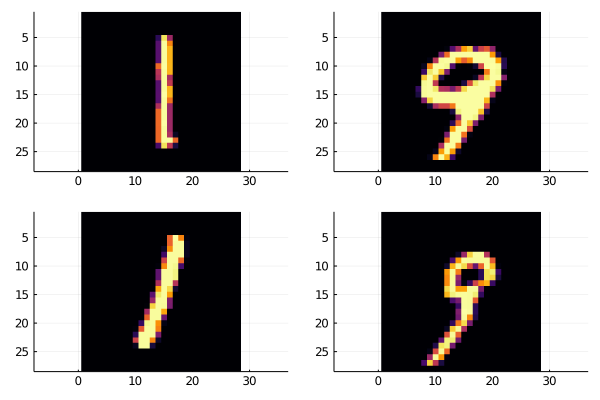

In [33]:
plot( heatmap( reshape(xi_small[:,64],28,28) , yflip = true, aspect_ratio=:equal, legend=false), 
    heatmap( reshape(xi_small[:,609],28,28) , yflip = true, aspect_ratio=:equal, legend=false),
    heatmap( reshape(xi_small[:,36],28,28) , yflip = true, aspect_ratio=:equal, legend=false),
    heatmap( reshape(xi_small[:,502],28,28) , yflip = true, aspect_ratio=:equal, legend=false) 
    )

Note that we can access the $i$th image by reading the $i$th column of the matrix "xi_small". This can be done in Julia's syntax as "xi_small[:,i]".

Meanwhile, in the training set, each entry in "yi_small" is a binary number ($\pm 1$) representing whether the image of the same index is an "1" or "9". For example, the label associated with the above images are:

In [34]:
print("Label for image 64: ", yi_small[64], "  Label for image 609: ", yi_small[609], "\n")
print("Label for image 36: ", yi_small[36], "  Label for image 502: ", yi_small[502], "\n")

Label for image 64: 1  Label for image 609: -1
Label for image 36: 1  Label for image 502: -1


As we see, the images of digit "1" are labeled as $+1$, while the images for digit "9" are labeled as $-1$.

## Formulating the Logistics Regression Problem

Our goal is to train a linear classifier $w \in \mathbb{R}^n$ for the SVM. In particular, $w$ minimizes the logistics regression objective:

$$ \min_{ w \in \mathbb{R}^n } f(w) := \frac{1}{m} \sum_{i=1}^m \log( 1 + \exp( - y_i w^\top x_i ) ) + \frac{1}{2m} \| w \|^2 $$

Observe that the optimization problem is an unconstrained nonlinear program. We recall that the gradient descent method follows the recursion below:

- Step 0: initialize with $w^{(0)}$ and set the iteration counter as $k=0$.
- Step 1: compute the gradient $\nabla f(w^{(k)})$
- Step 2: compute the next iterate $w^{(k+1)} = w^{(k)} - \gamma \nabla f(w^{(k)})$ (where $\gamma$ is chosen from a certain rule, e.g., backtracking, constant, diminishing, etc.)
- Step 3: check for optimality condition, e.g., if $|| \nabla f(w^{(k)}) || \leq \epsilon$.
- Step 4: if not satisfied, increase $k$ as $k \leftarrow k+1$ and return to step 1.

To facilitate our programming, it is convenient construct a function that computes the objective function on the training data.

In Julia, a function can be defined using the syntax "function" followed by the name of the function. E.g., suppose that we want to construct a function taking a scalar $x$ as input, and output $x^2$, we can do:

In [35]:
function xsq(x)
    return x^2
end

xsq (generic function with 1 method)

In [36]:
print("output of the function to input `1' is ", xsq(1), "; to input `3' is ", xsq(3))

output of the function to input `1' is 1; to input `3' is 9

Our objective function is quite complicated, but it can be computed as a function below:

In [37]:
function obj_fct( w , x, y )
    value_tmp = 0.5*norm(w)^2;
    for ii = 1 : size(x,2)
        value_tmp += log( 1 + exp( -y[ii]* dot(w,x[:,ii]) ))
    end
    return value_tmp/size(x,2)
end

obj_fct (generic function with 1 method)

As we see, we can use for loops and different types of functions within a function. 

The gradient is given by:

$$ \nabla f(w) = \frac{1}{m} w - \frac{1}{m}\sum_{i=1}^m \frac{1}{1 + \exp(y_i w^\top x_i)} y_i x_i $$

which can be computed by the following function:

In [38]:
function grd_fct( w, x, y )
    vec_tmp = copy(w);
    for ii = 1 : size(x,2)
        vec_tmp += -y[ii]*x[:,ii] /(1 + exp( y[ii]* dot(w,x[:,ii]) ))
    end
    return vec_tmp/size(x,2)
end

grd_fct (generic function with 1 method)

**Tracking the Progress**: To track the progress of the gradient descent method, we shall use the value of the objective function as well as the actual performance of the classifier, i.e., how accurate does it work on the testing dataset.  

In the SVM classifier, given $w \in \mathbb{R}^n$ and an image $x \in \mathbb{R}^n$, the classifier outputs a binary number:

$$ \hat{y} = {\rm sign}( w^\top x ) $$

such that the image is classified as "1" if $\hat{y} = 1$; or it is classified as "9" if $\hat{y} = -1$.

To evaluate the error probability the current classifier make on the "testing" dataset (which is unseen by the algorithm), we calculate:

$$ \text{error rate} = \frac{\text{number of errors made}}{\text{number of testing images}} = \frac{1}{\text{number of testing images}} \sum_i \mathbb{1}( {\rm sign}( w^\top x_i ) \neq y_i )$$

where the summation runs over all the testing images. 
This error rate can be computed by the following function:

In [39]:
function err_rate( w, x, y ) # "x" is a matrix of the testing images, "y" is the vector of labels
    total_err = 0;
    for ii = 1 : size(x,2)
        total_err += ( sign(dot(w,x[:,ii])) != y[ii] )
    end
    return total_err/size(x,2)
end

err_rate (generic function with 1 method)

## Applying Gradient Method on Logistics Regression

The following code implements the gradient method with an initialization of all all-zero vector

In [40]:
n = 784; max_iter = 1000; epsilon = 1e-3; w_init = zeros(n,1); 

The above code specifies the step size and the initialization used. 

In [41]:
# initialize the variables for tracking progresses
store_obj = []; push!(store_obj,obj_fct( w_init, xi_small, yi_small ));
store_err = []; push!(store_err,err_rate( w_init, images_test, labels_test));
# begin the iteration
w = copy(w_init); gamma = 0.5; # the step size is chosen Heuristically
for iter = 1 : max_iter
    w = w - gamma*grd_fct( w, xi_small, yi_small );
    push!( store_obj, obj_fct( w, xi_small, yi_small ) );
    push!( store_err, err_rate( w, images_test, labels_test));
    if norm(grd_fct(w,xi_small,yi_small)) <= epsilon
        break
    end
end

The above code-sniplet is a standard for loop implementing the gradient descent method with constant step size. 

An curious syntax here is the 2 lines related to "store_obj" and "store_err", which are intended for storing the objective value and the testing error over the iterations. In the above, we have first created an empty array, then we "push" the values of the objective / testing error to it using the "push!" function. This is a Julia-specific syntax. 

Lastly, let us visualize the progress of the gradient descent method:

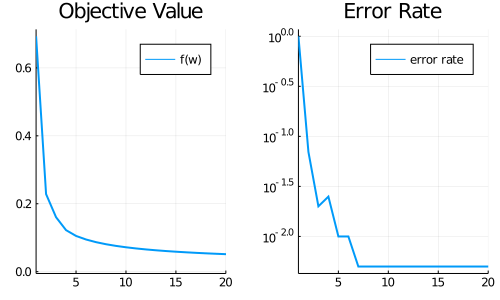

In [42]:
plot( 
    plot( store_obj , labels = "f(w)", lw=2, title = "Objective Value" , size=(500,300) ),
    plot( store_err , labels = "error rate", lw=2, yaxis=:log, title ="Error Rate", size=(500,300))
)
plot!(xlims=(1,50)) # This line specifies the limit of "x-axis" as iteration 1 to 20

In terms of minimizing the objective function, the gradient descent method shows convergence roughly after 150 iterations. Meanwhile, the error rate quickly decreases to less than 1% and saturates there.

## Interpreting the Result

Observe that the trained classifier has a 0.5% of error, corresponding to mis classifying $1$ image out of the $200$ in the testing set. We are curious into learning what does that image look like. To find it, we use the following code:

In [43]:
for i = 1 : size(images_test,2)
    if sign( dot(w, images_test[:,i]) ) != labels_test[i] 
        print("image number ", i, " is mis-classified. \n")
    end
end

image number 136 is mis-classified. 


We learnt that it is image number 136 from the testing set. Let's observe how the image actually looks like:

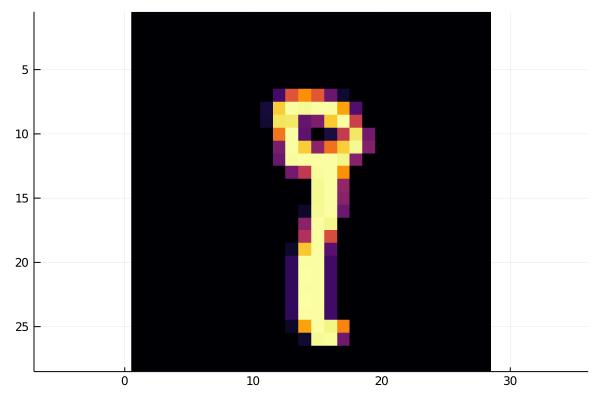

In [44]:
heatmap( reshape(images_test[:,136],28,28) , yflip = true, aspect_ratio=:equal, legend=false) 

In [45]:
print("the label for the image is ", labels_test[136])

the label for the image is -1

The image is labeled as a "9" but as we can see it looks like a "1" even to us.

Lastly, it is interesting to see how does the trained classifier $w$ look like:

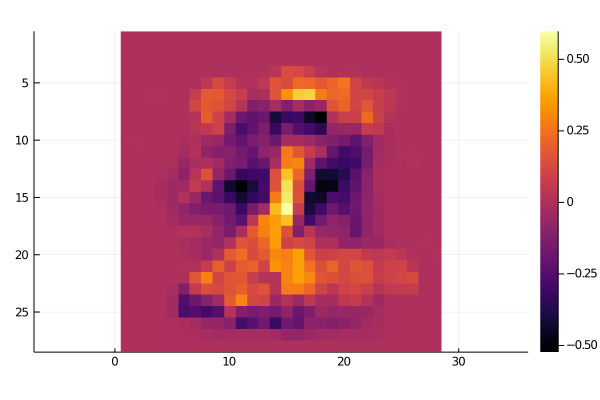

In [46]:
heatmap( reshape(w,28,28), yflip = true, aspect_ratio=:equal)

We observe $w$ is mostly zero on the boundary of this image, this makes sense because the images for both "1" and "9" are dark/black over the boundary.

## In-class / After-class Exercise

Implement and track the progress of the gradient descend method on the logistics regression problem using different step size rules:

- Diminishing step size (at iteration $k$, set $\gamma = 1/k$).
- Backtracking line search (see the lecture note)

Comment on the performance (e.g., in terms of convergence rate) of using different method.

#### Diminishing step size

This implementation should be straightforward by following the previously coded gradient descent (we just need to change the way we compute the step size):

In [47]:
# initialize the tracking variables
w = copy(w_init);
store_obj_1 = []; push!(store_obj_1,obj_fct( w_init, xi_small, yi_small ));
store_err_1 = []; push!(store_err_1,err_rate( w_init, images_test, labels_test));
# begin the iteration
for iter = 1 : max_iter
    # your code here
    gamma = 1/iter;
    w = w - gamma*grd_fct( w, xi_small, yi_small );
    push!( store_obj_1, obj_fct( w, xi_small, yi_small ) );
    push!( store_err_1, err_rate( w, images_test, labels_test));
    if norm(grd_fct(w,xi_small,yi_small)) <= epsilon
        break
    end
end

#### Backtracking line search

A convenient way for implementing this variant of gradient method is to first implement a function which finds the best step size by backtracking. Recall that the backtracking line search finds the $\gamma$ until
$$ f( w - \gamma \nabla f(w) ) < f(w) - \alpha \gamma || \nabla f(w) ||^2 $$
holds. Therefore, this function should take the following inputs:

- $\alpha, \beta$: the parameters as specified in the lecture slides
- "obj_fct": the function used to compute the objective value at different $w$
- "w_cur": the current $w$
- "grd_vec": the gradient vector evaluated at the current $w$

We will write the function as follows:

In [48]:
function backtracking(alpha, beta, obj_fct, w_cur, grd_vec, xi, yi)
    # your code here
    f_cur = obj_fct( w_cur, xi, yi ); gamma = 1;
    while ( obj_fct( w_cur - gamma*grd_vec, xi,yi ) >= f_cur - alpha*gamma*norm(grd_vec)^2 )
        gamma = gamma*beta;
    end
    return gamma
end

backtracking (generic function with 1 method)

We next modify the gradient descent program below (replacing the step size choice with the backtracking function):

In [49]:
store_obj_2 = []; push!(store_obj_2,obj_fct( w_init, xi_small, yi_small ));
store_err_2 = []; push!(store_err_2,err_rate( w_init, images_test, labels_test));
# begin the iteration
w = copy(w_init); 
for iter = 1 : max_iter
    # your code here
    grd_vec = grd_fct(w,xi_small,yi_small);
    gamma = backtracking( 0.5, 0.95, obj_fct, w, grd_vec, xi_small, yi_small );
    w = w - gamma*grd_fct( w, xi_small, yi_small );
    push!( store_obj_2, obj_fct( w, xi_small, yi_small ) );
    push!( store_err_2, err_rate( w, images_test, labels_test));
    if norm( grd_vec ) <= epsilon
        break
    end
end

#### Comparing between different methods

We can next compare the performance with different step size rules as follows

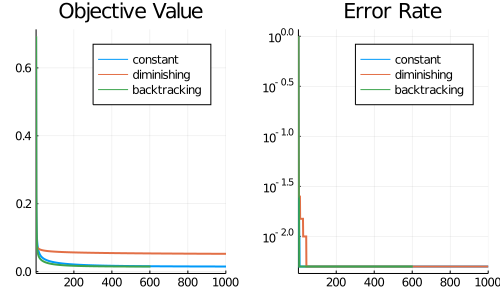

In [54]:
plot( 
    plot( [store_obj,store_obj_1,store_obj_2] , labels = ["constant" "diminishing" "backtracking"], lw=2, title = "Objective Value" , size=(500,300) ),
    plot( [store_err,store_err_1,store_err_2] , labels = ["constant" "diminishing" "backtracking"], lw=2, yaxis=:log, title ="Error Rate", size=(500,300))
    )
plot!(xlims=(1,1000)) # This line specifies the limit of "x-axis" as iteration 1 to 20

## Newton's Method

Finally, let's try to implement the Newton's method for the optimization problem. To do this, we need a function that computes the Hessian of $f(w)$.

Note that the Hessian is given by:

$$ \nabla^2 f(w) = \frac{1}{m} I + \frac{1}{m}\sum_{i=1}^m \frac{1}{(1 + \exp(y_i w^\top x_i))^2} x_i x_i^\top $$

In [51]:
function hess_fct( w, x, y )
    # your code here, it should resemble the grd_fct defined in the above.
    mat_tmp = I;
    for ii = 1 : size(x,2)
        mat_tmp += x[:,ii]*x[:,ii]' / (1 + exp( y[ii]* dot(w,x[:,ii]) ))^2
    end
    return mat_tmp/size(x,2)
end

hess_fct (generic function with 1 method)

In [60]:
store_obj_3 = []; push!(store_obj_3,obj_fct( w_init, xi_small, yi_small ));
store_err_3 = []; push!(store_err_3,err_rate( w_init, images_test, labels_test));
# begin the iteration
w = copy(w_init); 
for iter = 1 : max_iter
    # your code here (it should invovle a call to the Hessian function you've written
    w = w - 0.1* (hess_fct(w,xi_small,yi_small))^-1 * grd_fct( w, xi_small, yi_small );
    
    # Store the current objective & error rate
    push!( store_obj_3, obj_fct( w, xi_small, yi_small ) );
    push!( store_err_3, err_rate( w, images_test, labels_test));
    if norm(grd_fct(w,xi_small,yi_small)) <= epsilon
        break
    end
    
    if iter%5 == 1
        print( "grad norm = ", norm(grd_fct(w,xi_small,yi_small)), "\n" )
    end
end

grad norm1.2052708715666636
grad norm0.37400608572931443
grad norm0.002637603906947861
grad norm0.001083814801057031


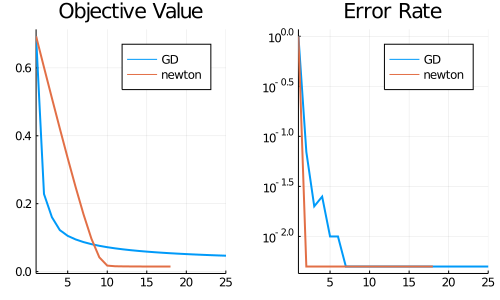

In [64]:
plot( 
    plot( [store_obj,store_obj_3] , labels = ["GD" "newton"], lw=2, title = "Objective Value" , size=(500,300) ),
    plot( [store_err,store_err_3] , labels = ["GD" "newton"], lw=2, yaxis=:log, title ="Error Rate", size=(500,300))
    )
plot!(xlims=(1,25)) # This line specifies the limit of "x-axis" as iteration 1 to 20